<a href="https://colab.research.google.com/github/aminar034/ml1000-p1/blob/working_models/Project1_wine_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working code for wine classification problem.

**Dataset:**
* wine quality data retrieved from https://archive.ics.uci.edu/ml/datasets/Wine+Quality

* using the white wine csv only (had more observations than the red)


**Problem:**
* how do we test if the wine is high quality and should be priced accordingly?

# Executive Summary

**Abstract**

Quality is the degree to which a product meets specified requirements. To assess white wine quality, it is essential to select measure(s) that directly impact its quality.  In this study, we will be using physicochemical properties as features to evaluate the white wine’s quality attribute.  

**Background**

Our client is the retailer and wholesaler, Liquor Control Board of Ontario (LCBO). They would like to assess white wine quality to determine its prices as part of their research quality management.  Wine quality can be assessed either by physicochemical properties or by human sensory testing. Physicochemical properties include pH, dissolved salts, sodium levels, the acidity, and density.  As the demand of high-quality wine is increasing, the need for better prediction of wine quality in an efficient and convenient way is also in high demand.  Human sensory testing of wine quality can be a time-consuming process and open to interpretation. Another method in wine informatics is exploring machine learning techniques to classify various wine attributes such as quality based on wine quality evaluation. 

**Objective**

The objective of this study is to use binary classification model to assess white wine quality based on several important physicochemical properties. 


## Install packages and load in dataset

* When using colab, need to install pycaret everytime
* read in the wine quality dataset using the "raw" link from the git repository
  * alternatively can use any other url for the data that ends in .csv
  * trying to avoid linking the colab notebook to git, google drive or local server for reproducibility

In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 46.7 MB/s eta 0:00:00
 

In [ ]:
import pandas as pd

df_path = 'https://raw.githubusercontent.com/DeepCodeSec/ml1000-p1/working_models/data/winequality-white.csv'  
dataset = pd.read_csv(df_path, 
                   sep=';') #the separater in the raw data is ;. need to indicate so columns are found
dataset.head()


In [ ]:
# What is the distribution of the target variable (quality)
dataset.describe()

### Recode quality to a binary label
**Original**: quality of wine rated from 0-10 with 10 as the best

Above shows that the minimum rating was a 3 and max is 9. The mean and median are both ~6.

According to this website, a rating of 7+ is good wine. It isn't a big deal if the classes are imbalanced, that just dictates which performance metric we use. It is more important to create our classes based on real-world knowledge.  https://vineroutes.com/wine-rating-system/#:~:text=Wines%20rated%2089%20and%20above,outstanding%20for%20its%20particular%20type.

**New**: binary label (target variable) of 'standard' or 'high quality' where a rating of 7 or above  is high quality and 6 or below is standard

In [ ]:
import numpy as np

#add binary classification label
dataset['new_quality'] = np.where(dataset['quality'] > 6, 
                               'high_quality',
                               'standard')
dataset.head(100)

In [ ]:
#drop old quality column and rename new
dataset = dataset.drop(columns=['quality']) #drops old column
dataset = dataset.rename(columns={'new_quality':'quality'}) #renames back to quality

dataset.head() #double check it did what we asked

## Exploratory analysis report

The code below automatically creates an exploratory data analysis report. The report is output as an html file in the local files (see the files pane on the left.

For the final report/project we will want to highlight specific aspects from the EDA document that justify our decisions below and code these explicitly. For example if we use a parametric classifier that needs independent (non-correlated) predictors, we would want to show the correlation matrix in the notebook that gets published and comment on how much/little the predictors are correlated and how we are dealing with them.

In [ ]:
#Load libraries for exploratory analysis
!pip3 install pandas_profiling --upgrade
import pandas_profiling
from pandas_profiling import ProfileReport
import pandas as pd

pr = ProfileReport(dataset)

pr.to_file(output_file="EDA.html")

Dataset has:
* 12 variables (11 numeric predictors and 1 categorical target/label)
* 4898 observations
* no missing values

Distributions:
* imbalanced label classes (~20% high quality and 80% standard)
  * again, this is not an issue, it just tells us that we need to think about undersampling and choose the appropriate performance metric
* most of the predictor variables are fairly normally distributed
* alcohol, volatile acidity, and residual sugar are not normally distributed, so we can consider transforming these columns (eg log transformation) if needed


Interactions:
* skipping, not super interesting for classification because pycaret is just going to run a dozen models anyway. We are more interested in the interactions for a regression type problem where, for example, the revenue from tv x radio adcertisements is predicted better than from tv ads or radio adds alone

Correlations:
* moderate correlation between density + residual sugar, density + alcohol, alcohol + chlorides
* for now leaving, but revisit for fine tuning if we are getting poor performance

Duplicate rows:
* therer are a number of duplicate rows. It is hard to say if these are genuinely duplicates and should be removed, or if they are coincidental duplicates (ie 2 wine samples happen to have the same measurements)


## Split dataset

* 5% test set (unseen until after model is finalized) 
* The remaining 95% will be split in the pycaret setup function

First we remove the 5% test set before any feature engineering to avoid data leakage. Test set is randomly shuffled.

After feature engineering, the remaining data will be split into training and validation sets that follow the same distribution of target labels (ie using stratified sampling).

We also need to take into consideration the sampling method because we have imbalanced classes
* under/over sample
* stratified sampling 
* etc

In [ ]:
# split data into 95% and 5%
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

In [ ]:
data.head()

In [ ]:
data_unseen.head()

## Data cleaning decisions

* Do outlier/anomaly analysis here. Since the dataset has lower number of observations, opt for solutions that retain as much data as possible (eg capping the data as opposed to removing rows)
* make decisions about transformations etc here

In [ ]:
data.info()

* No categorical variables other than the target (class) variable, so no categorical encoding necessary
* Recall from EDA that alcohol, volatile acidity, and residual sugar were not normally distributed, so we can consider transforming these columns (eg log transformation) if needed. For now I will leave and see how the modle does.
* We already know that the data does not contain missing values (from the source and from EDA), so no imutation or row removal necessary.
* We could do feature selection, but since we only have 11 predictors, it is safe to start with a brute force model (ie we just use everything and see what happens)
* Should check for outliers and decide what to do with them. See below:

### Outlier analysis

Two options: 
* 1) When lots of observations in dataset and only a few rows with outlier values (for any column), just remove rows containing outliers.
* 2) When fewer observations and more rows containing outlier values, cap the values at the IQR (interquartile range)

In [ ]:
# Outlier analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cols = list(data.columns)

#Create boxplot for every numeric feature (cols 0-11) to show outliers
for col in cols[0:-1]:
  plt.figure()
  sns.boxplot(data[col])
  plt.show()


The boxplots indicate that most of the predictors contain outlier values. Some of these predictors, like chlorides, contain a lot of outliers. Therefore, if we manipulate these values, we'll want to cap them. Sometimes outliers are meaningful to our investigation, so it doesn't make sense to remove or cap. https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

For now, I'm doing nothing. We can discuss as a group.

In [ ]:
# finding the 1st quartile
q1 = np.quantile(dataset['fixed acidity'], 0.25)
print(q1)
# finding the 3rd quartile
q3 = np.quantile(dataset['fixed acidity'], 0.75)
print(q3)

med = np.median(dataset['fixed acidity'])
print(med)

# finding the iqr region
iqr = q3-q1

# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

# finding outliers
outliers = dataset[(dataset['fixed acidity'] <= lower_bound) | (dataset['fixed acidity'] >= upper_bound)]
outliers['fixed acidity'].count()

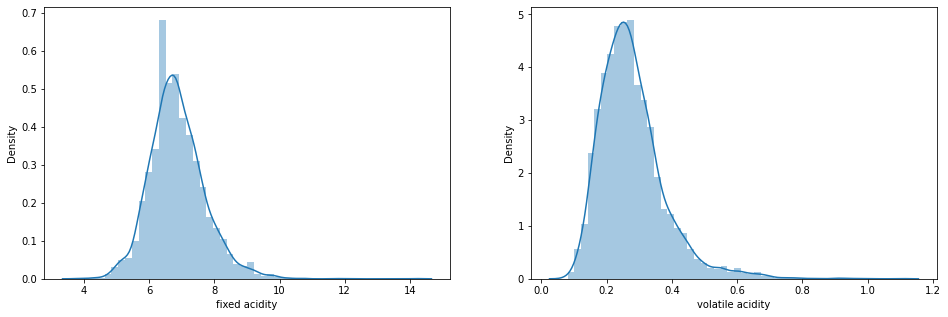

In [ ]:
# plot the distribution plots for the features
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(dataset['fixed acidity'])
plt.subplot(1,2,2)
sns.distplot(dataset['volatile acidity'])
plt.show()

In [ ]:
ub = dataset['fixed acidity'].mean() + 3*dataset['fixed acidity'].std()
lb = dataset['fixed acidity'].mean() - 3*dataset['fixed acidity'].std()

print("Highest allowed",ub)
print("Lowest allowed",lb)

In [ ]:
nd_outliers = dataset[(dataset['fixed acidity'] > ub) | (dataset['fixed acidity'] < lb)]
nd_outliers['fixed acidity'].count()

## Training classifier models

Now the main event, training classifiers.

In [ ]:
from pycaret.classification import *

In [ ]:
#setup experiment
exp_P1clf = setup(data = data, target = 'quality', data_split_stratify = True, 
                  session_id = 123)


https://pycaret.readthedocs.io/en/stable/api/classification.html

* default train split is 0.7 training 0.3 validation
* data_split_stratify = True means that the training and validation sets have the same proportion of each class (ie high_quality vs standard wines) 

Options:

* could set transformation to true to make data more gaussian (normal distribution)
* can remove multicolinarity (deals with correlated predictors)
* can also set to do automatic feature selection


In [ ]:
#Find best model
best_model = compare_models()

The top 3 classifiers, extra trees, random forest, and light gradient boosting all have similar accuracy, auc and F1 scores. Let's tune all three and see which of the tuned models performs best.

**Note:**
Since we have imbalanced classes, accuracy is not our most important performance metric. Let's talk about it as a group, but for now I'll tune for F1

In [ ]:
# train a extra tree model
et = create_model('et')

In [ ]:
# train a random forest model
rf = create_model('rf')

In [ ]:
# train a lgb model
lgb = create_model('lightgbm')

### Tuning the models

Use the tune_model function to find the optimal hyperparameters for the model. Performance metric will be F1 as a stand-in

In [ ]:
# tune extra tree model
tuned_et = tune_model(et, optimize='F1')

In [ ]:
evaluate_model(tuned_et)

In [ ]:
# tune random forest model
tuned_rf = tune_model(rf, optimize='F1')

In [ ]:
evaluate_model(tuned_rf)
#random forest is actually a poor choice at least when we optimize F1 because it never predicts high quality

In [ ]:
# tune lgb model
tuned_lgb = tune_model(lgb, optimize='F1')

In [ ]:
evaluate_model(tuned_lgb)

## Discuss and choose

* Was F1 actually a good metric to optimize on? Is there another performance metric that would be better? Revist our business question (and then potentially re-tune the models)
* select best performer

In [ ]:
#ET performance on the validation set
pred_holdout_et = predict_model(tuned_et)
pred_holdout_et.head()

In [ ]:
#RF performance on the validation set
pred_holdout_rf = predict_model(tuned_rf)
pred_holdout_rf.head()

Remember that rf was predicting everything as standard (and we see this in the confidence score. All decisions are 0.7848 confidence

In [ ]:
#LGB performance on the validation set
pred_holdout_lgb = predict_model(tuned_lgb)
pred_holdout_lgb.head()

Better overall accuracy and higher F1 compared to extra tree model. For now let's say we take the LGB model.

In [ ]:
#Finalize model and retrain on the combined training and validation sets before testing on the 5% holdout
final_lgb = finalize_model(tuned_lgb)

In [ ]:
print(final_lgb)

#### Predict on unseen data (5% holdout)

In [ ]:
# 5% sample witheld in the beginning
data_unseen.head()

In [ ]:
# drop the quality column (classification label) from data_unseen
data_unseen.drop('quality', axis = 1, inplace = True)
data_unseen.head()

In [ ]:
#predict class using the finalized model
pred_unseen = predict_model(final_lgb, data=data_unseen)
pred_unseen.head()

In [ ]:
#save model
save_model(final_lgb,'lgb_final_pipeline')